In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# @title
# rename the filenames because of invalid names of web

'''
import string

def rename_images(directory):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Generiere einen zufälligen Dateinamen
            random_name = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
            new_filename = random_name + os.path.splitext(filename)[1]
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
            print(f"{filename} umbenannt in {new_filename}")


image_directory = 'data/keine Autos/'
rename_images(image_directory)
'''

'\nimport string\n\ndef rename_images(directory):\n    for filename in os.listdir(directory):\n        if filename.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\', \'.gif\', \'.bmp\')):\n            # Generiere einen zufälligen Dateinamen\n            random_name = \'\'.join(random.choices(string.ascii_letters + string.digits, k=10))\n            new_filename = random_name + os.path.splitext(filename)[1]\n            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))\n            print(f"{filename} umbenannt in {new_filename}")\n\n\nimage_directory = \'data/keine Autos/\'\nrename_images(image_directory)\n'

In [3]:
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Remove dodgy images

In [5]:
# remove also .DS files, problem with macOS

from PIL import Image

data_dir = r'/content/drive/MyDrive/Colab Notebooks/Computer Vision Project/data'
image_exts = ['jpeg', 'jpg', 'png']

for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            if os.path.isfile(image_path):
                try:
                    with Image.open(image_path) as img:
                        img.verify()  # Überprüft, ob das Bild lesbar ist
                except Exception:
                    os.remove(image_path)
                    print(f'Beschädigtes Bild gefunden und entfernt: {image_path}')

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [6]:
# huge problem here at model training, break up while one epoch
# solution from stackoverflow:

# detect all images that are webp but has the ending .jpg,
# webp img cannot be recognized by tensorflow

from pathlib import Path
import imghdr

data_dir = r'/content/drive/MyDrive/Colab Notebooks/Computer Vision Project/data'
image_extensions = [".jpeg", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(img)

In [7]:
#### test

#img = cv2.imread(os.path.join('data', 'Autos', '585.jpg'))
#img.shape
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show()

2. Load data using Keras Utils

In [8]:
data = tf.keras.utils.image_dataset_from_directory( # building a data pipeline
    r'/content/drive/MyDrive/Colab Notebooks/Computer Vision Project/data',
    image_size=(224, 224),
    #image_size=(224, 224),
    batch_size=32,
    color_mode = 'rgb',
    seed=42
)

data = data.map(lambda x,y: (x/255, y)) # every single data in our data pipeline is scaled

buffer_size = len(data)

data = data.shuffle(buffer_size, seed = 42)

data_iterator = data.as_numpy_iterator() # allowing acceess to our data pipeline

# run this cell to get another batch from the iterator
batch = data_iterator.next() # allowing a batch back, batch_size default 32. after one batch -> update weights & loss function

batch[0].shape # -> 32, 256, 256, 3 (batch_size, width, height, rgb)
batch[1] # Class 0: Autos, Class 1: keine Autos
scaledBatch_min=batch[0].min()
scaledBatch_max=batch[0].max()
print(scaledBatch_min, scaledBatch_max)

Found 1229 files belonging to 2 classes.
0.0 1.0


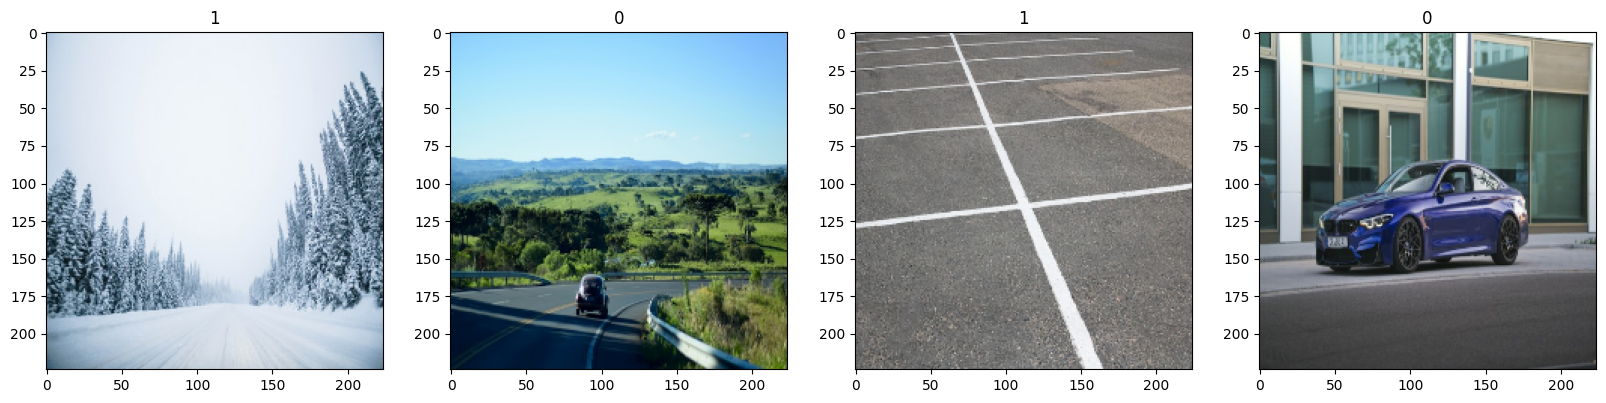

In [9]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

3. Preprocessing data

3.1 Scale Data

3.2 Split Data

In [10]:
print(len(data)) # -> 30 batches times 32 imgs each batch

train_size = int(len(data)*.7) # -> 28
val_size = int(len(data)*.2)+2 # -> 9
test_size = int(len(data)*.1) # -> 4

print(train_size, val_size, test_size)

print(train_size+val_size+test_size) # -> 30

'''no use of sklearn train_test_split needed'''

# actually taking and skipping from dataset, take/skip prevents overlapping and enables sequence
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

39
27 9 3
39


4.  Build deep learning model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),  # Für zufällige Rotation
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),  # Für Kontrastanpassungen
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), # Für zufällige Zoom (kann auch als Streckung angesehen werden)
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(height=200, width=200)
])

def apply_augmentation(image, label):
    image = data_augmentation(image)
    return image, label

train = train.map(apply_augmentation)

4.1 Train our DNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#model.summary()

In [14]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
hist = model.fit(train, epochs = 30, validation_data=val, callbacks=[tensorboard_callback]) # training components

Epoch 1/30
27/27 [==============================] - 25s 713ms/step - loss: 0.6936 - accuracy: 0.6071 - val_loss: 0.5873 - val_accuracy: 0.6914
Epoch 2/30
27/27 [==============================] - 23s 707ms/step - loss: 0.6237 - accuracy: 0.6710 - val_loss: 0.4728 - val_accuracy: 0.8160
Epoch 3/30
27/27 [==============================] - 23s 707ms/step - loss: 0.5578 - accuracy: 0.7136 - val_loss: 0.4299 - val_accuracy: 0.7986
Epoch 4/30
27/27 [==============================] - 24s 714ms/step - loss: 0.5103 - accuracy: 0.7763 - val_loss: 0.4609 - val_accuracy: 0.7807
Epoch 5/30
27/27 [==============================] - 23s 715ms/step - loss: 0.5922 - accuracy: 0.7041 - val_loss: 0.4328 - val_accuracy: 0.8299
Epoch 6/30
27/27 [==============================] - 24s 718ms/step - loss: 0.5524 - accuracy: 0.7420 - val_loss: 0.4802 - val_accuracy: 0.7917
Epoch 7/30
27/27 [==============================] - 24s 715ms/step - loss: 0.5248 - accuracy: 0.7609 - val_loss: 0.3143 - val_accuracy: 0.8646

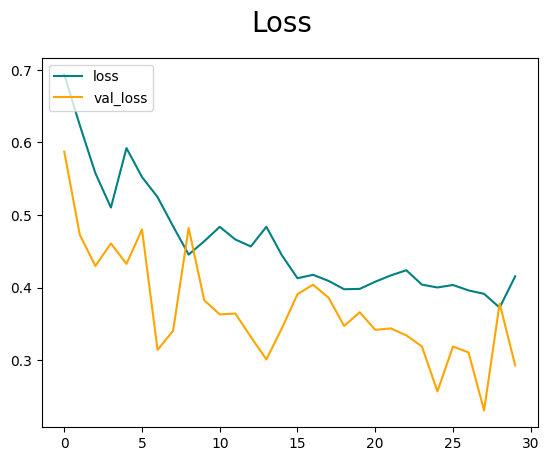

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# no noise in loss plot means no jumping around in gradient descent and stuck in local minima, little noise is good

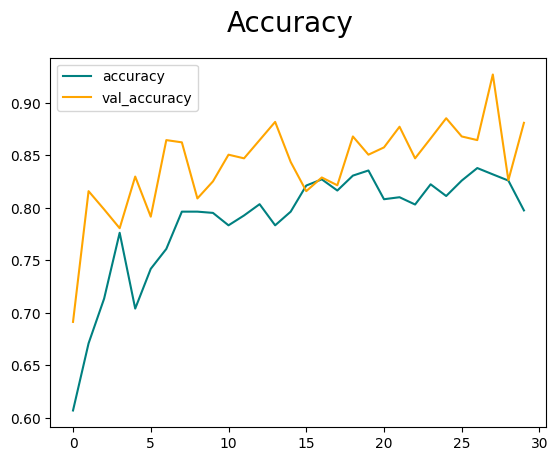

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate Performance

Evaluate

In [18]:
len(test)

3

1/1 [==============================] - 0s 76ms/step
Precision: 0.7083333134651184
Recall: 0.8292682766914368
Accuracy: 0.78125


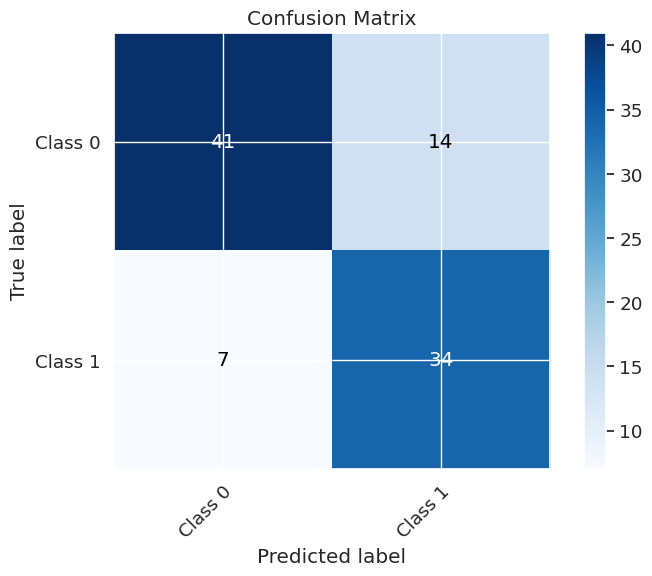

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


pre = Precision()
re = Recall()
acc = BinaryAccuracy()

y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Annahme: Schwellenwert für binäre Klassifikation
    y_true.extend(y)
    y_pred.extend(yhat_binary)
    pre.update_state(y, yhat_binary)
    re.update_state(y, yhat_binary)
    acc.update_state(y, yhat_binary)

# Ausgabe der Metriken
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

# Plotte die Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    sns.set(font_scale=1.2)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Annahme: Du hast zwei Klassen (0 und 1), passe dies entsprechend an.
class_names = ["Class 0", "Class 1"]

plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [20]:
from tensorflow.keras.models import load_model
#model.save(os.path.join('models', 'thirdtraining.h5'))